<a href="https://colab.research.google.com/github/Moshikaa/BERT-and-RoBERTa-based-Sentiment-Analysis/blob/main/BERT_and_RoBERTa_based_Sentiment_Analysis1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [127]:
from google.colab import drive #Importing the google drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [128]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

# For data processing
import re, string
import demoji
import nltk

from sklearn import preprocessing
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split


# For working with Naive Bayes
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

#Transformers for bert and roberta
from transformers import BertTokenizerFast
from transformers import TFBertModel
from transformers import RobertaTokenizerFast
from transformers import TFRobertaModel

#keras
import tensorflow as tf
from tensorflow import keras


#metrics
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix

#set seed for reproducibility
seed=42

#set style for plots
sns.set_style("whitegrid")
sns.despine()
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlepad=10)

<ipython-input-128-8ab4285eb44b>:43: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


<Figure size 640x480 with 0 Axes>

In [129]:
!pip install demoji

In [130]:
#Loading data
df_train=pd.read_csv('/content/drive/MyDrive/Covid_19 tweets/Corona_NLP_train.csv',encoding='ISO-8859-1')
df_test = pd.read_csv('/content/drive/MyDrive/Covid_19 tweets/Corona_NLP_test.csv')

In [131]:
df_train.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [132]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB


In [133]:
df_train['TweetAt'] = pd.to_datetime(df_train['TweetAt'])
#convert the date column 'TweetAt' to pandas datetime format to improve its usability in the further analysis.

<ipython-input-133-005b3f6fd5ac>:1: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df_train['TweetAt'] = pd.to_datetime(df_train['TweetAt'])


In [134]:
#Remove duplicates
df_train.drop_duplicates(subset='OriginalTweet',inplace=True)

In [135]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   UserName       41157 non-null  int64         
 1   ScreenName     41157 non-null  int64         
 2   Location       32567 non-null  object        
 3   TweetAt        41157 non-null  datetime64[ns]
 4   OriginalTweet  41157 non-null  object        
 5   Sentiment      41157 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 2.2+ MB


In [136]:
#Exploratory Data Analysis
#Tweets per day
tweets_per_day = df_train['TweetAt'].dt.strftime('%m-%d').value_counts().sort_index().reset_index(name='counts')

<ipython-input-137-dc9b291b1784>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='index', y='counts', data=tweets_per_day,edgecolor = 'black',errorbar=('ci', False), palette='Blues_r')


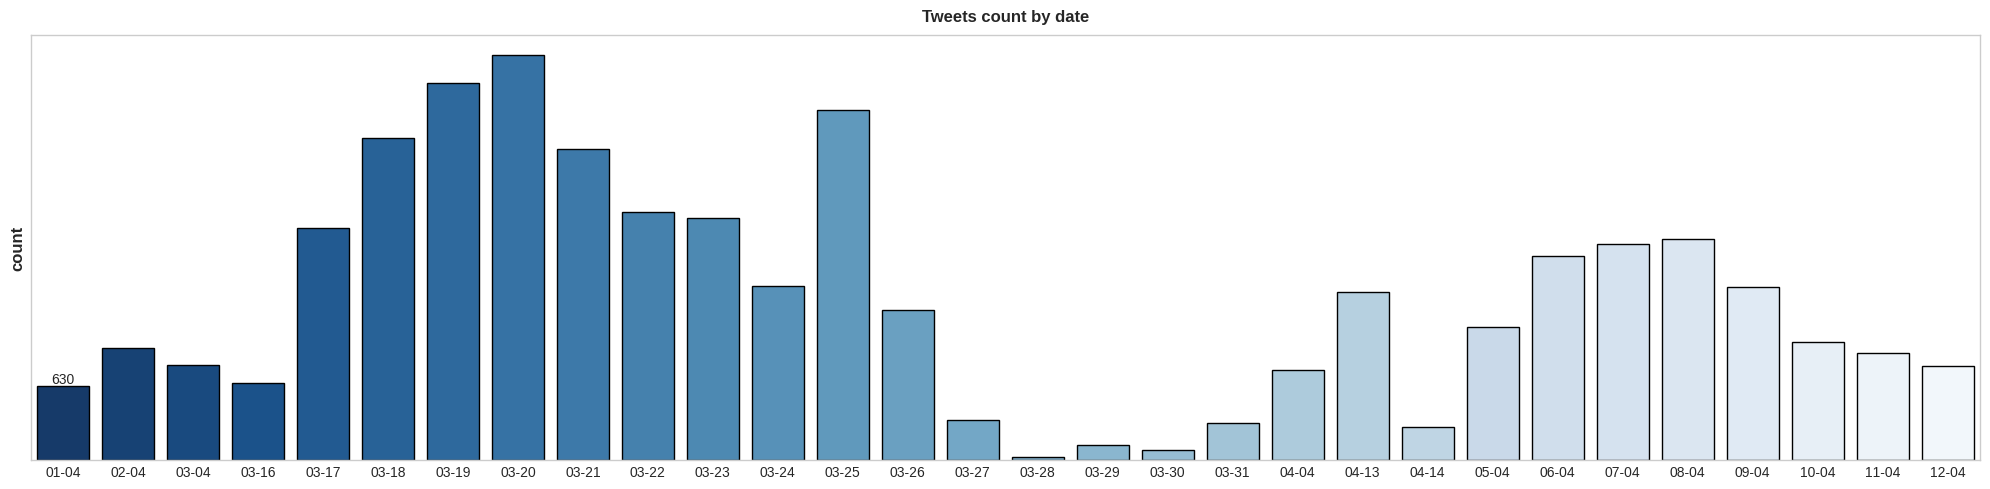

In [137]:
plt.figure(figsize=(20,5))
ax = sns.barplot(x='index', y='counts', data=tweets_per_day,edgecolor = 'black',errorbar=('ci', False), palette='Blues_r')
plt.title('Tweets count by date')
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

In [138]:
#Tweets by country
tweets_per_country = df_train['Location'].value_counts().loc[lambda x : x > 100].reset_index(name='counts')

<ipython-input-139-79641756506b>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='index', y='counts', data=tweets_per_country,edgecolor = 'black',errorbar=('ci', False), palette='Spectral')


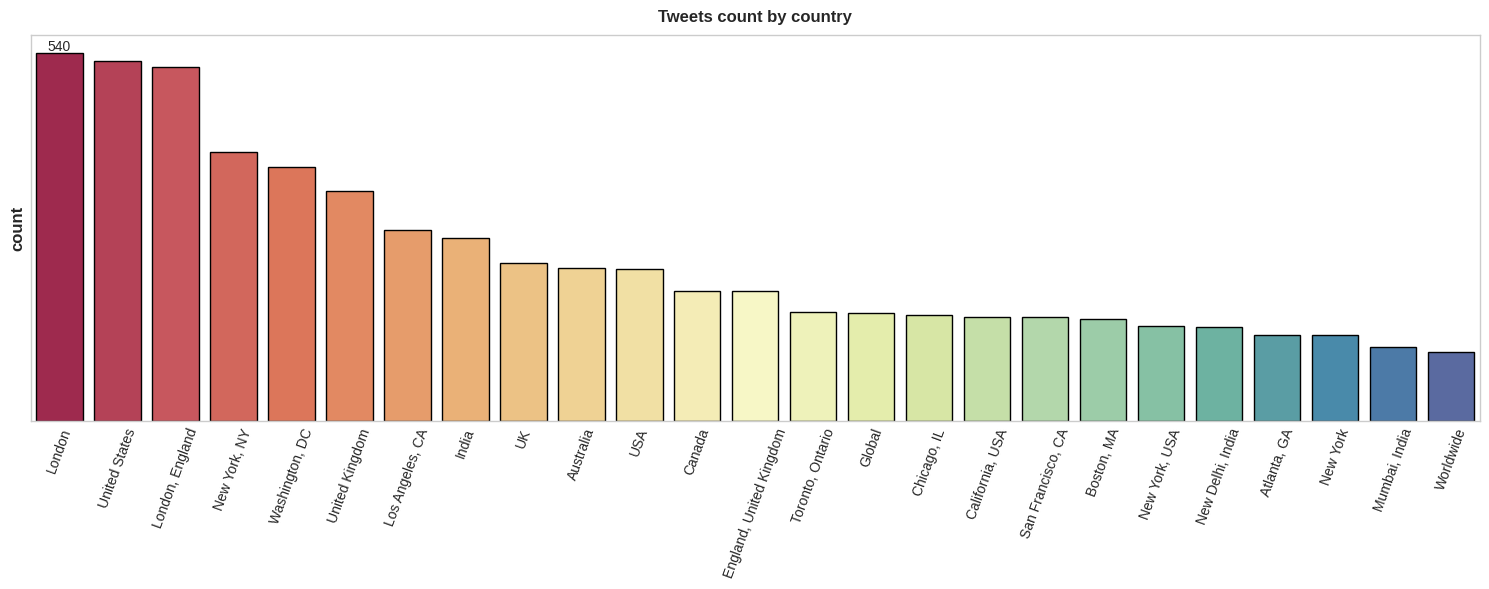

In [139]:
plt.figure(figsize=(15,6))
ax = sns.barplot(x='index', y='counts', data=tweets_per_country,edgecolor = 'black',errorbar=('ci', False), palette='Spectral')
plt.title('Tweets count by country')
plt.xticks(rotation=70)
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

In [140]:
#Deep Cleaning of Tweets
df_train = df_train[['OriginalTweet','Sentiment']]
df_test = df_test[['OriginalTweet','Sentiment']]

In [141]:
#Creating function to clean tweets
#Clean emojis from text
def strip_emoji(text):
    return demoji.replace(text, '') #remove emoji

#Remove punctuations, links, mentions and \r\n new line characters
def strip_all_entities(text):
    text = text.replace('\r', '').replace('\n', ' ').replace('\n', ' ').lower() #remove \n and \r and lowercase
    text = re.sub(r"(?:\@|https?\://)\S+", "", text) #remove links and mentions
    text = re.sub(r'[^\x00-\x7f]',r'', text) #remove non utf8/ascii characters such as '\x9a\x91\x97\x9a\x97'
    banned_list= string.punctuation + 'Ã'+'±'+'ã'+'¼'+'â'+'»'+'§'
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    return text

#clean hashtags at the end of the sentence, and keep those in the middle of the sentence by removing just the # symbol
def clean_hashtags(tweet):
    new_tweet = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', tweet)) #remove last hashtags
    new_tweet2 = " ".join(word.strip() for word in re.split('#|_', new_tweet)) #remove hashtags symbol from words in the middle of the sentence
    return new_tweet2

#Filter special characters such as & and $ present in some words
def filter_chars(a):
    sent = []
    for word in a.split(' '):
        if ('$' in word) | ('&' in word):
            sent.append('')
        else:
            sent.append(word)
    return ' '.join(sent)

def remove_mult_spaces(text): # remove multiple spaces
    return re.sub("\s\s+" , " ", text)

In [142]:
texts_new = [] #For train data
for t in df_train.OriginalTweet:
    texts_new.append(remove_mult_spaces(filter_chars(clean_hashtags(strip_all_entities(strip_emoji(t))))))

In [143]:
texts_new_test = [] #For test data
for t in df_test.OriginalTweet:
    texts_new_test.append(remove_mult_spaces(filter_chars(clean_hashtags(strip_all_entities(strip_emoji(t))))))

In [144]:
#Showing clean data alone
df_train['text_clean'] = texts_new
df_test['text_clean'] = texts_new_test

In [145]:
df_train['text_clean'].head()

0                                              and and
1    advice talk to your neighbours family to excha...
2    coronavirus australia woolworths to give elder...
3    my food stock is not the only one which is emp...
4    me ready to go at supermarket during the covid...
Name: text_clean, dtype: object

In [146]:
df_test['text_clean'].head()

0    trending new yorkers encounter empty supermark...
1    when i couldnt find hand sanitizer at fred mey...
2    find out how you can protect yourself and love...
3    panic buying hits newyork city as anxious shop...
4    toiletpaper dunnypaper coronavirus coronavirus...
Name: text_clean, dtype: object

In [147]:
df_train['text_clean'][1:8].values

array(['advice talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist gp set up online shopping accounts if poss adequate supplies of regular meds but not over order',
       'coronavirus australia woolworths to give elderly disabled dedicated shopping hours amid covid19 outbreak',
       'my food stock is not the only one which is empty please dont panic there will be enough food for everyone if you do not take more than you need stay calm stay safe covid19france covid19 covid19 coronavirus confinement confinementotal confinementgeneral',
       'me ready to go at supermarket during the covid19 outbreak not because im paranoid but because my food stock is litteraly empty the coronavirus is a serious thing but please dont panic it causes shortage coronavirusfrance restezchezvous stayathome confinement',
       'as news of the regions first confirmed covid19 case came out of sullivan county last week people 

In [148]:
#create a column to host the lenght of the cleaned text, to check if by cleaning the text we removed too much text or almost entirely the tweet
text_len = []
for text in df_train.text_clean:
    tweet_len = len(text.split())
    text_len.append(tweet_len)


In [149]:
df_train['text_len'] = text_len

In [150]:
text_len_test = []
for text in df_test.text_clean:
    tweet_len = len(text.split())
    text_len_test.append(tweet_len)

In [151]:
df_test['text_len'] = text_len_test

<ipython-input-152-f8099c383fa0>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='text_len', data=df_train[df_train['text_len']<10], palette='mako')


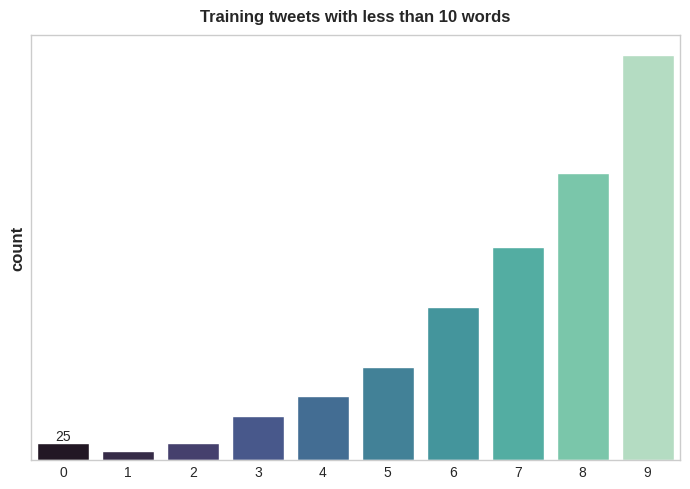

In [152]:
plt.figure(figsize=(7,5))
ax = sns.countplot(x='text_len', data=df_train[df_train['text_len']<10], palette='mako')
plt.title('Training tweets with less than 10 words')
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

<ipython-input-153-7979c0899f38>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='text_len', data=df_test[df_test['text_len']<10], palette='mako')


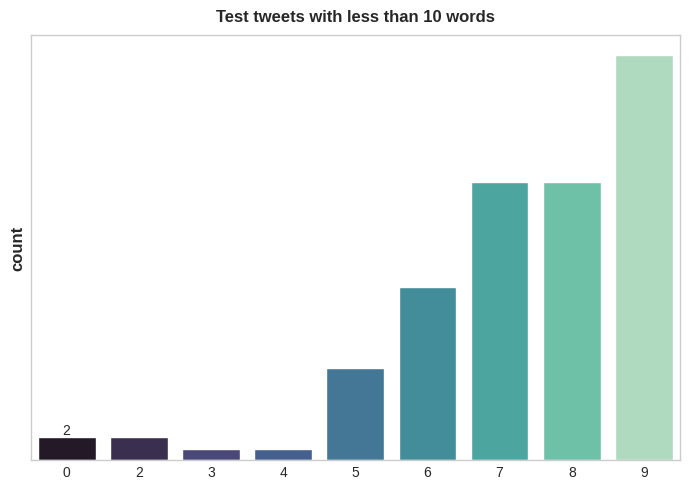

In [153]:
plt.figure(figsize=(7,5))
ax = sns.countplot(x='text_len', data=df_test[df_test['text_len']<10], palette='mako')
plt.title('Test tweets with less than 10 words')
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

In [154]:
#Drop the tweets with 0 word count(that contained only links, emojis and hashtags)
print(f" DF SHAPE: {df_train.shape}")
print(f" DF TEST SHAPE: {df_test.shape}")

 DF SHAPE: (41157, 4)
 DF TEST SHAPE: (3798, 4)


In [155]:
df_train = df_train[df_train['text_len'] > 4] #MIN word length =4

In [156]:
df_test = df_test[df_test['text_len'] > 4]

In [157]:
print(f" DF SHAPE: {df_train.shape}")
print(f" DF TEST SHAPE: {df_test.shape}")

 DF SHAPE: (40935, 4)
 DF TEST SHAPE: (3792, 4)


In [158]:
import pandas as pd

df_train1 = df_train.sample(frac=0.01, random_state=42)

# Display the shape of the reduced DataFrame
print("Reduced DataFrame shape:", df_train1.shape)


Reduced DataFrame shape: (409, 4)


In [159]:
import pandas as pd

df_test1 = df_test.sample(frac=0.01, random_state=42)

# Display the shape of the reduced DataFrame
print("Reduced DataFrame shape:", df_test1.shape)

Reduced DataFrame shape: (38, 4)


In [160]:
#Deep Cleaning of the Training Data
#tokenization from bert
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

In [161]:
token_lens = []

for txt in df_train1['text_clean'].values:
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))

max_len=np.max(token_lens)

In [162]:
print(f"MAX TOKENIZED SENTENCE LENGTH: {max_len}")

MAX TOKENIZED SENTENCE LENGTH: 77


In [163]:
#Let's check the long tokenized sentences (with more than 80 tokens )
token_lens = []

for i,txt in enumerate(df_train1['text_clean'].values):
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))
    if len(tokens)>80:
        print(f"INDEX: {i}, TEXT: {txt}")

In [164]:
#These sentences are not in English, hence they have to be dropped
df_train1['token_lens'] = token_lens

In [165]:
df_train1 = df_train1.sort_values(by='token_lens', ascending=False)
df_train1.head(20)

,OriginalTweet,Sentiment,text_clean,text_len,token_lens
1697,I work at a grocery store.\r\r\nWe wont get an...,Positive,i work at a grocery store we wont get any toil...,37,77
32780,This was a first! I've never had to walk into ...,Negative,this was a first ive never had to walk into a ...,46,67
30712,Girl get me some toilet paper and some bacon! ...,Neutral,girl get me some toilet paper and some bacon h...,26,67
3338,hey #Hoarders stop buying the #tolietpaper i k...,Extremely Negative,hey hoarders stop buying the tolietpaper i kno...,53,66
35383,Hi I am a student currently out of work due to...,Positive,hi i am a student currently out of work due to...,55,65
17849,"ÂContemplating the Value of ButtpaperÂ, 2020...",Positive,contemplating the value of buttpaper 2020 jmfs...,27,63
27791,Our disposable medical face masks are from a g...,Neutral,our disposable medical face masks are from a g...,34,63
30639,$ALB $SQM EV demand was slowing before COVID-1...,Negative,alb sqm ev demand was slowing before covid19s ...,44,62
16889,?? #Trump\r\r\n????????\r\r\nIf you have any l...,Negative,trump if you have any lysol spray wipes or han...,41,62
39345,#HomeDepot in the #USA doing nicely on the bac...,Positive,homedepot in the usa doing nicely on the back ...,44,61


In [166]:
df_train1 = df_train1.iloc[12:]
df_train1.head()

,OriginalTweet,Sentiment,text_clean,text_len,token_lens
38612,IÂm a little confused with #Covid-19. @ the s...,Negative,im a little confused with covid19 the supermar...,49,60
12858,Hardest part of quarantine? I live in a 30 ft ...,Extremely Negative,hardest part of quarantine i live in a 30 ft c...,46,60
13678,Hoomans daughter works in healthcare Looking a...,Negative,hoomans daughter works in healthcare looking a...,49,60
38526,1) I went to supermarket today only to see man...,Negative,1 i went to supermarket today only to see many...,43,60
22779,"This is the job I've had for 3 years, btw. I w...",Neutral,this is the job ive had for 3 years btw i was ...,45,60


In [167]:
#We will shuffle it and reset the index
df_train1 = df_train1.sample(frac=1).reset_index(drop=True)

In [168]:
##Deep Cleaning of the Testing Data
token_lens_test = []

for txt in df_test1['text_clean'].values:
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens_test.append(len(tokens))

max_len=np.max(token_lens_test)

In [169]:
print(f"MAX TOKENIZED SENTENCE LENGTH: {max_len}")

MAX TOKENIZED SENTENCE LENGTH: 65


In [170]:
token_lens_test = []

for i,txt in enumerate(df_test1['text_clean'].values):
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens_test.append(len(tokens))
    if len(tokens)>80:
        print(f"INDEX: {i}, TEXT: {txt}")

In [171]:
df_test1['token_lens'] = token_lens_test

In [172]:
df_test1 = df_test1.sort_values(by='token_lens', ascending=False)
df_test1.head(10)

,OriginalTweet,Sentiment,text_clean,text_len,token_lens
1491,"Dang these people are out of control, I'll tel...",Neutral,dang these people are out of control ill tell ...,50,65
2765,Im gonna need grocery stores to start putting...,Extremely Negative,im gonna need grocery stores to start putting ...,54,64
457,Trump Derangement Syndrome is spreading faster...,Negative,trump derangement syndrome is spreading faster...,36,64
1406,Word of the day: #hamsteren.\r\r\nIt means hoa...,Positive,word of the day hamsteren it means hoarding or...,45,59
1805,About to walk into a grocery store and shop fo...,Negative,about to walk into a grocery store and shop fo...,39,57
3550,As COVID-19 hysteria hits a crescendo this wee...,Extremely Negative,as covid19 hysteria hits a crescendo this week...,45,57
2445,Last week it was bog roll the the dickheads we...,Negative,last week it was bog roll the the dickheads we...,43,56
263,Im not discounting the danger for some while ...,Positive,im not discounting the danger for some while a...,49,54
2707,@silverado1954 Only time will tell. I suspect ...,Extremely Negative,only time will tell i suspect that covid19 wil...,45,51
2091,"Overheard at the Supermarket, patrons unconcer...",Positive,overheard at the supermarket patrons unconcern...,37,51


In [173]:
df_test1 = df_test1.iloc[5:]
df_test1.head(3)

,OriginalTweet,Sentiment,text_clean,text_len,token_lens
3550,As COVID-19 hysteria hits a crescendo this wee...,Extremely Negative,as covid19 hysteria hits a crescendo this week...,45,57
2445,Last week it was bog roll the the dickheads we...,Negative,last week it was bog roll the the dickheads we...,43,56
263,Im not discounting the danger for some while ...,Positive,im not discounting the danger for some while a...,49,54


In [174]:
#Drop the tweets in other language
df_test1 = df_test1.sample(frac=1).reset_index(drop=True)

In [175]:
#Analysis of the column "Sentiment"
df_train1['Sentiment'].value_counts()

Positive              117
Negative              103
Neutral                68
Extremely Positive     57
Extremely Negative     52
Name: Sentiment, dtype: int64

In [176]:
#Mapping numbers to categories
df_train1['Sentiment'] = df_train1['Sentiment'].map({'Extremely Negative':0,'Negative':0,'Neutral':1,'Positive':2,'Extremely Positive':2})

In [177]:
df_test1['Sentiment'] = df_test1['Sentiment'].map({'Extremely Negative':0,'Negative':0,'Neutral':1,'Positive':2,'Extremely Positive':2})

In [178]:
df_test1.head()

,OriginalTweet,Sentiment,text_clean,text_len,token_lens
0,Due to uncertainty over people are staying at ...,0,due to uncertainty over people are staying at ...,38,41
1,So awful that people are having to self isolat...,0,so awful that people are having to self isolat...,44,50
2,**UPDATE** As we continue to monitor the effec...,0,update as we continue to monitor the effects o...,38,45
3,How to stock a pantry #Coronavirus https://t.c...,1,how to stock a pantry coronavirus,6,9
4,"This is Texas, yall!\r\r\n\r\r\nA couple hire...",2,this is texas yall a couple hire a mariachi ba...,28,35


In [179]:
df_train1.head()

,OriginalTweet,Sentiment,text_clean,text_len,token_lens
0,@piersmorgan @DavidJoBrexit Only real differen...,0,only real difference between spanish flu and c...,39,44
1,@EBBerger (What shocked me in this thread is t...,0,what shocked me in this thread is to learn tha...,43,50
2,Saks Fifth Avenue has closed their Manhattan F...,0,saks fifth avenue has closed their manhattan f...,40,51
3,@SiouxsieW and any other experts. Question in ...,2,and any other experts question in our house ov...,42,45
4,New Musk hit PTA supermarket stores today.\r\r...,1,new musk hit pta supermarket stores today new ...,18,40


In [180]:
#Class Balancing by RandomOverSampler
ros = RandomOverSampler()
train_x, train_y = ros.fit_resample(np.array(df_train1['text_clean']).reshape(-1, 1), np.array(df_train1['Sentiment']).reshape(-1, 1));
train_os = pd.DataFrame(list(zip([x[0] for x in train_x], train_y)), columns = ['text_clean', 'Sentiment']);

In [181]:

train_os['Sentiment'].value_counts()

0    174
2    174
1    174
Name: Sentiment, dtype: int64

In [182]:
#Splitting Train-Test-Validation
X = train_os['text_clean'].values
y = train_os['Sentiment'].values

In [183]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, stratify=y, random_state=seed)

In [184]:
X_test = df_test['text_clean'].values
y_test = df_test['Sentiment'].values

In [185]:
#One Hot Encodng
y_train_le = y_train.copy()
y_valid_le = y_valid.copy()
y_test_le = y_test.copy()

In [186]:
ohe = preprocessing.OneHotEncoder()
y_train = ohe.fit_transform(np.array(y_train).reshape(-1, 1)).toarray()
y_valid = ohe.fit_transform(np.array(y_valid).reshape(-1, 1)).toarray()
y_test = ohe.fit_transform(np.array(y_test).reshape(-1, 1)).toarray()

In [187]:
print(f"TRAINING DATA: {X_train.shape[0]}\nVALIDATION DATA: {X_valid.shape[0]}\nTESTING DATA: {X_test.shape[0]}" )

TRAINING DATA: 469
VALIDATION DATA: 53
TESTING DATA: 3792


In [188]:
#BERT
MAX_LEN=128

In [189]:
def tokenize(data,max_len=MAX_LEN) :
    input_ids = []
    attention_masks = []
    for i in range(len(data)):
        encoded = tokenizer.encode_plus(
            data[i],
            add_special_tokens=True,
            max_length=MAX_LEN,
            padding='max_length',
            return_attention_mask=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids),np.array(attention_masks)

In [190]:
train_input_ids, train_attention_masks = tokenize(X_train, MAX_LEN)
val_input_ids, val_attention_masks = tokenize(X_valid, MAX_LEN)
test_input_ids, test_attention_masks = tokenize(X_test, MAX_LEN)

In [191]:
#Modeling
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [192]:
def create_model(bert_model, max_len=MAX_LEN):

    ##params###
    opt = tf.keras.optimizers.Adam(learning_rate=1e-5, beta_2=1e-7)
    loss = tf.keras.losses.CategoricalCrossentropy()
    accuracy = tf.keras.metrics.CategoricalAccuracy()


    input_ids = tf.keras.Input(shape=(max_len,),dtype='int32')

    attention_masks = tf.keras.Input(shape=(max_len,),dtype='int32')

    embeddings = bert_model([input_ids,attention_masks])[1]

    output = tf.keras.layers.Dense(3, activation="softmax")(embeddings)

    model = tf.keras.models.Model(inputs = [input_ids,attention_masks], outputs = output)

    model.compile(opt, loss=loss, metrics=accuracy)


    return model

In [193]:
model = create_model(bert_model, MAX_LEN)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128)]                0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 128)]                0         []                            
                                                                                                  
 tf_bert_model (TFBertModel  TFBaseModelOutputWithPooli   1094822   ['input_1[0][0]',             
 )                           ngAndCrossAttentions(last_   40         'input_2[0][0]']             
                             hidden_state=(None, 128, 7                                           
                             68),                                                             

In [194]:
history_bert = model.fit([train_input_ids,train_attention_masks], y_train, validation_data=([val_input_ids,val_attention_masks], y_valid), epochs=1, batch_size=32)

15/15 [==============================] - 731s 45s/step - loss: 1.1500 - categorical_accuracy: 0.3433 - val_loss: 1.1473 - val_categorical_accuracy: 0.3396


In [195]:
#Result
result_bert = model.predict([test_input_ids,test_attention_masks])

119/119 [==============================] - 1531s 13s/step


In [196]:
y_pred_bert =  np.zeros_like(result_bert)
y_pred_bert[np.arange(len(y_pred_bert)), result_bert.argmax(1)] = 1

In [200]:
from sklearn.metrics import confusion_matrix

In [241]:
def conf_matrix(y_true, y_pred, title):
    # Generate the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot the confusion matrix
    plt.figure(figsize=(4, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(title)
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()

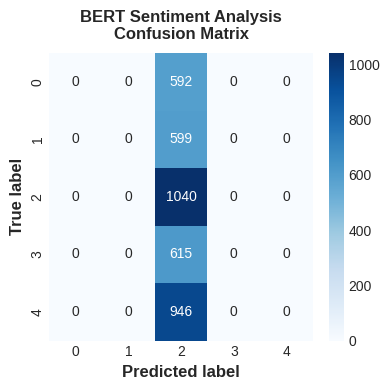

In [242]:
conf_matrix(y_test.argmax(1), y_pred_bert.argmax(1),'BERT Sentiment Analysis\nConfusion Matrix')

In [247]:
print(y_test)

[[1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 ...
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]]


In [246]:
y_pred_bert

array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]])

In [204]:
from sklearn.metrics import classification_report

In [206]:
y_pred_bert = np.concatenate((y_pred_bert, np.zeros((len(y_test) - len(y_pred_bert), y_pred_bert.shape[1]), dtype=int)))

In [208]:
print(y_test.shape)
print(y_pred_bert.shape)

(3792, 5)
(3792, 3)


In [211]:
#RoBERTa
tokenizer_roberta = RobertaTokenizerFast.from_pretrained("roberta-base")

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [212]:
#Chceking longest tokenised sentence by roberta
token_lens = []

for txt in X_train:
    tokens = tokenizer_roberta.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))
max_length=np.max(token_lens)
max_length

62

In [213]:
MAX_LEN=128

In [214]:
#tokenisation function
def tokenize_roberta(data,max_len=MAX_LEN) :
    input_ids = []
    attention_masks = []
    for i in range(len(data)):
        encoded = tokenizer_roberta.encode_plus(
            data[i],
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',
            return_attention_mask=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids),np.array(attention_masks)

In [215]:
train_input_ids, train_attention_masks = tokenize_roberta(X_train, MAX_LEN)
val_input_ids, val_attention_masks = tokenize_roberta(X_valid, MAX_LEN)
test_input_ids, test_attention_masks = tokenize_roberta(X_test, MAX_LEN)

In [219]:
#Modeling
def create_model(bert_model, max_len=MAX_LEN):

    opt = tf.keras.optimizers.Adam(learning_rate=1e-5, beta_2=1e-7)
    loss = tf.keras.losses.CategoricalCrossentropy()
    accuracy = tf.keras.metrics.CategoricalAccuracy()

    input_ids = tf.keras.Input(shape=(max_len,),dtype='int32')
    attention_masks = tf.keras.Input(shape=(max_len,),dtype='int32')
    output = bert_model([input_ids,attention_masks])
    output = output[1]
    output = tf.keras.layers.Dense(3, activation=tf.nn.softmax)(output)
    model = tf.keras.models.Model(inputs = [input_ids,attention_masks],outputs = output)
    model.compile(opt, loss=loss, metrics=accuracy)
    return model

In [220]:
roberta_model = TFRobertaModel.from_pretrained('roberta-base')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.bias', 'roberta.embeddings.position_ids', 'lm_head.dense.weight']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

In [221]:
model = create_model(roberta_model, MAX_LEN)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 128)]                0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 128)]                0         []                            
                                                                                                  
 tf_roberta_model_1 (TFRobe  TFBaseModelOutputWithPooli   1246456   ['input_3[0][0]',             
 rtaModel)                   ngAndCrossAttentions(last_   32         'input_4[0][0]']             
                             hidden_state=(None, 128, 7                                           
                             68),                                                           

In [222]:
history_2 = model.fit([train_input_ids,train_attention_masks], y_train, validation_data=([val_input_ids,val_attention_masks], y_valid), epochs=1, batch_size=30)

16/16 [==============================] - 694s 41s/step - loss: 1.1215 - categorical_accuracy: 0.3006 - val_loss: 1.0903 - val_categorical_accuracy: 0.3962


In [223]:
#Results
result_roberta = model.predict([test_input_ids,test_attention_masks])

119/119 [==============================] - 1539s 13s/step


In [224]:
y_pred_roberta =  np.zeros_like(result_roberta)
y_pred_roberta[np.arange(len(y_pred_roberta)), result_roberta.argmax(1)] = 1

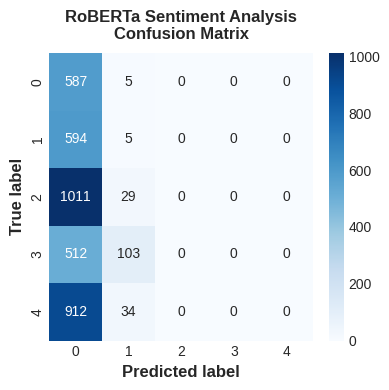

In [243]:
conf_matrix(y_test.argmax(1),y_pred_roberta.argmax(1),'RoBERTa Sentiment Analysis\nConfusion Matrix')

In [253]:
import numpy as np
from sklearn.metrics import classification_report, accuracy_score

# Convert y_test to class indices using argmax
y_test_indices1 = np.argmax(y_test, axis=1)

# Convert y_pred_roberta to class indices using argmax
y_pred_indices1 = np.argmax(y_pred_bert, axis=1)
y_pred_indices2 = np.argmax(y_pred_roberta, axis=1)

# Create a classification report
target_names = ['Exteremly negative','Negative','Neutral','Positive','Extremely positive']  # Replace with your actual class names
classification_rep_bert = classification_report(y_test_indices1, y_pred_indices1, target_names=target_names)
classification_rep_roberta = classification_report(y_test_indices1, y_pred_indices2, target_names=target_names)

#Accuracy
accuracy1 = accuracy_score(y_test_indices1, y_pred_indices1)
accuracy2 = accuracy_score(y_test_indices1, y_pred_indices2)

print("Classification Report for BERT :\n", classification_rep_bert)
print("Classification Report for RoBERTa:\n", classification_rep_roberta)
print("Accuracy for BERT :", accuracy1)
print("Accuracy for RoBERTa :", accuracy2)


Classification Report for BERT :
                     precision    recall  f1-score   support

Exteremly negative       0.00      0.00      0.00       592
          Negative       0.00      0.00      0.00       599
           Neutral       0.27      1.00      0.43      1040
          Positive       0.00      0.00      0.00       615
Extremely positive       0.00      0.00      0.00       946

          accuracy                           0.27      3792
         macro avg       0.05      0.20      0.09      3792
      weighted avg       0.08      0.27      0.12      3792

Classification Report for RoBERTa:
                     precision    recall  f1-score   support

Exteremly negative       0.16      0.99      0.28       592
          Negative       0.03      0.01      0.01       599
           Neutral       0.00      0.00      0.00      1040
          Positive       0.00      0.00      0.00       615
Extremely positive       0.00      0.00      0.00       946

          accuracy       

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif